In [1]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from ml_algs.neural_nets.simple_net import SimpleNet

current_dir = %pwd

In [2]:
with open('./data/names.txt', 'r') as f:
    names = [line.strip() for line in f.readlines()]

In [3]:
x_str_to_int = {}
y_str_to_int = {}
all_chars = sorted(list(set('.abcdefghijklmnopqrstuvwxyz')))

new_idx = 0
for i, ch1 in enumerate(all_chars):
    y_str_to_int[ch1] = i
     
    for j, ch2 in enumerate(all_chars):
        if ch1 == '.' and ch2 =='.':
            continue
        
        x_str_to_int[ch1+ch2] = new_idx
        new_idx += 1

x_str_to_int[' .'] = new_idx

x_int_to_char = {v: k for k, v in x_str_to_int.items()}
y_int_to_str = {v: k for k, v in y_str_to_int.items()}

In [4]:
xs_first, ys_first = [], []
xs_last, ys_last = [], []

for name in names:
    splitted = name.split(' ')
    first_name = " ." + splitted[0].lower() + "."
    last_name = " ." + splitted[1].lower() + "."

    for i in range(2, len(first_name)):
        xs_first.append(x_str_to_int[first_name[i-2:i]])
        ys_first.append(y_str_to_int[first_name[i]])

    for i in range(2, len(last_name)):
        xs_last.append(x_str_to_int[last_name[i-2:i]])
        ys_last.append(y_str_to_int[last_name[i]])

xs_first = torch.tensor(xs_first)
ys_first = torch.tensor(ys_first)
xs_last = torch.tensor(xs_last)
ys_last = torch.tensor(ys_last)

In [5]:
xs_first_train, x_tmp, ys_first_train, y_tmp = train_test_split(xs_first, ys_first, train_size=0.8)
xs_first_val, xs_first_test, ys_first_val, ys_first_test = train_test_split(x_tmp, y_tmp, test_size=0.5)

xs_last_train, x_tmp, ys_last_train, y_tmp = train_test_split(xs_last, ys_last, train_size=0.8)
xs_last_val, xs_last_test, ys_last_val, ys_last_test = train_test_split(x_tmp, y_tmp, test_size=0.5)

In [6]:
nnet_first = SimpleNet(
    input_len=len(x_str_to_int), 
    output_len=len(y_str_to_int), 
    learning_rate=30, 
    regularization_rate=0.01,
    random_seed=42
)

nnet_last = SimpleNet(
    input_len=len(x_str_to_int), 
    output_len=len(y_str_to_int), 
    learning_rate=30, 
    regularization_rate=0.01,
    random_seed=42
)

xenc_first_train = F.one_hot(xs_first_train, num_classes=len(x_str_to_int)).float()
xenc_last_train = F.one_hot(xs_last_train, num_classes=len(x_str_to_int)).float()

In [7]:
nnet_first.train(xenc_first_train, ys_first_train, n_epochs=20)

3.808420181274414
3.7114343643188477
3.540046215057373
3.3486125469207764
3.1629135608673096
2.9505512714385986
2.7597150802612305
2.5965213775634766
2.4489269256591797
2.3506968021392822
2.304389476776123
2.2719669342041016
2.253485918045044
2.232966899871826
2.2289018630981445
2.216405153274536
2.1811251640319824
2.1665210723876953
2.1824839115142822
2.1989686489105225


In [8]:
nnet_last.train(xenc_last_train, ys_last_train, n_epochs=20)

3.7627382278442383
3.6723971366882324
3.5180745124816895
3.3406026363372803
3.185680627822876
3.052598476409912
2.916781187057495
2.7759084701538086
2.6583642959594727
2.5726048946380615
2.5119118690490723
2.4733219146728516
2.4441192150115967
2.4191298484802246
2.396327495574951
2.3672001361846924
2.35427188873291
2.3616862297058105
2.3606436252593994
2.3550853729248047


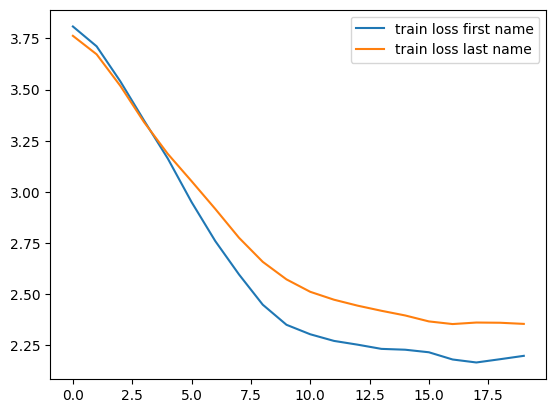

In [9]:
plt.plot(nnet_first.losses, label='train loss first name')
plt.plot(nnet_last.losses, label='train loss last name')
plt.legend()

In [12]:
g = torch.Generator().manual_seed(42)

xenc_first_val = F.one_hot(xs_first_val, num_classes=len(x_str_to_int)).float()
probs = nnet_first.eval(xenc_first_val)
loss_val = nnet_first.calculate_loss(probs, ys_first_val)

xenc_first_test = F.one_hot(xs_first_test, num_classes=len(x_str_to_int)).float()
probs = nnet_first.eval(xenc_first_test)
loss_test = nnet_first.calculate_loss(probs, ys_first_test)

print(loss_val)
print(loss_test)

tensor(2.2356, grad_fn=<AddBackward0>)
tensor(2.1913, grad_fn=<AddBackward0>)


In [13]:
g = torch.Generator().manual_seed(42)

xenc_last_val = F.one_hot(xs_last_val, num_classes=len(x_str_to_int)).float()
probs = nnet_last.eval(xenc_last_val)
loss_val = nnet_last.calculate_loss(probs, ys_last_val)

xenc_last_test = F.one_hot(xs_last_test, num_classes=len(x_str_to_int)).float()
probs = nnet_last.eval(xenc_last_test)
loss_test = nnet_last.calculate_loss(probs, ys_last_test)

print(loss_val)
print(loss_test)

tensor(2.3496, grad_fn=<AddBackward0>)
tensor(2.3464, grad_fn=<AddBackward0>)


In [9]:
def generate_name(nnet, generator):
    x_str = " ."
    out = ""

    while True:
        x_int = x_str_to_int[x_str]
        xenc = F.one_hot(torch.tensor([x_int]), num_classes=len(x_str_to_int)).float()
        probs = nnet.eval(xenc)

        y_int = torch.multinomial(probs, num_samples=1, replacement=True, generator=generator).item()
        y_str = y_int_to_str[y_int]

        if y_str == ".":
            break

        x_str = x_str[1] + y_str
        out += y_str
    
    return out

In [10]:
g = torch.Generator().manual_seed(42)

for _ in range(20):
    first_name = generate_name(nnet_first, g)
    last_name = generate_name(nnet_last, g)
    
    print(f"{first_name} {last_name}")

ames an
shley olley
joseph yo
try wellewilens
da parree
amanthanifert parciamillez
jenne buffss
stepheline gra
jamard willes
tannatriellin eixunnin
anne richan
amelaurey an
jenna whill
debethomaraca johns
kel gray
deberisamannatthew browelley
aley smith
ca coberrice
jen san
dan johns
